# Parse

In [1]:
import io
import os
import time
import shutil
import pathlib
import itertools
from contextlib import suppress


import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
from tqdm import tqdm
from lxml import html
from deepface import DeepFace
from chefboost import Chefboost as chef
from sklearn.metrics import confusion_matrix


import os
import sys
import inspect

# Import from parent directory
sys.path.insert(0, "C:/Projects/DateMatching/Model") 
import utils


tqdm.pandas()

In [2]:
def get_name(body: html.HtmlElement) -> str|None:
    with suppress(Exception):
        name = body.find_class('from_name')[0].text
        name = name.replace('\n', '').strip()
        return name

    
def get_photo(body: html.HtmlElement) -> str|bool:
    """returns string if there a image, True if there video and False if nothing"""
    with suppress(Exception):
        div = body.find_class('media_wrap')[0]
        a = div.getchildren()[0]
        photo = a.attrib['href']
        return photo
    
    with suppress(Exception):
        div = body.find_class('media_wrap')[0]
        a = div.getchildren()[0]
        if 'media_video' in a.attrib['class']:
            return True
    
    return False


def get_text(body: html.HtmlElement, text="") -> str|None:
    with suppress(Exception):
        div = body.find_class('text')[0]
        for t in div.itertext():
            text+= t
            
        text = text.replace('\n', '', 2).strip()
        return text

In [3]:
messages = []
for catalog in os.listdir('tg_data'):

    for file in os.listdir('tg_data/' + catalog):
        if '.html' in file:

            with open(f"tg_data/{catalog}/{file}", "r", encoding='utf-8') as f:
                _html = f.read()

            tree = html.fromstring(_html)
            history = tree.xpath("/html/body/div/div[2]/div")[0]
            history = history.find_class('message default clearfix')

            for message in history:
                body = message.find_class('body')[0]

                photo = get_photo(body) 
                if isinstance(photo, str):
                    photo = f"{catalog}/{photo}"
                    
                messages+= [{
                    'name': get_name(body),
                    'text': get_text(body),
                    'photo': photo,
                }]

# EDA

In [4]:
mutual = 0
initiative = 0
for msg in messages:
    if msg['text']: 
        if "Кому-то понравилась твоя анкета:" in msg['text']: 
            initiative += 1
            
        if "Есть взаимная симпатия" in msg['text']:
            mutual +=1
            

total_likes = 0 # i liked girl
total_dislikes = 0 # i disliked girl
total_response_g = 0 # i liked match
total_response_b = 0 # i disliked match 
for current, previous in zip(messages[1:], messages[:-1]):
    if previous['photo'] and previous['text'] and current['text']:
        
        if "Кому-то понравилась твоя анкета:" in previous['text']:
            if '👎' in current['text']:
                total_response_b += 1
                
            elif current['text'] in ['👍', '❤️']:
                total_response_g += 1

            
        else:
            if current['text'] in ['👍', '💌', '💌 / 📹']:
                total_likes += 1


            if '👎' in current['text']:
                total_dislikes += 1

In [5]:
print("Статистика @leomatchbot")
print("Количество поставленных лайков\дизлайков {0}\{1}".format(total_likes, total_dislikes))
print("{0} взаимных симпатий, конверсия: {1:.2f} %".format(mutual, mutual*100/total_likes))
print("Проявило инициативу (лайкнули первыми) {} женщин".format(initiative))
print("Всего понравился {} женщинам".format(mutual + initiative))

Статистика @leomatchbot
Количество поставленных лайков\дизлайков 90\26079
30 взаимных симпатий, конверсия: 33.33 %
Проявило инициативу (лайкнули первыми) 402 женщин
Всего понравился 432 женщинам


## Visualization

### Age, gender, emotion, race analyzing

In [6]:
def plot_imgs(imgs: list[np.ndarray], ncols=6, increase_factor=3, title=''):
    imgs_num = len(imgs)
    nrows = imgs_num//ncols + int(imgs_num%ncols > 0)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*increase_factor, nrows*increase_factor))
    fig.suptitle(title, fontsize=4*increase_factor)

    for ax, img in zip(axes.flatten(), imgs):
        ax.imshow(img)
        
    plt.show()

In [7]:
target_size=(224, 224)
empty_face = np.zeros((target_size[0], target_size[1], 3))

def find_faces_in_dir(path:str, back:str) -> np.ndarray:
    faces = []
    imgs_paths = []
    path = pathlib.Path(path)
    for img_path in [x for x in path.iterdir() if x.is_file()]:
        try:
            img_path = str(img_path)
            imgs_paths.append(img_path)
            face = DeepFace.detectFace(
                img_path=img_path, 
                target_size=target_size, 
                detector_backend=back,
            )
            if face.max() <= 1:
                #restore input in scale of [0, 255] because it was normalized in scale of  [0, 1] in preprocess_face
                face *= 255 
                
        except ValueError:
            face = empty_face


        faces.append(face)
        
    return np.array(faces), np.array(imgs_paths)

In [8]:
models = {}
models['age'] = DeepFace.build_model('Age')
models['gender'] = DeepFace.build_model('Gender')
models['emotion'] = DeepFace.build_model('Emotion')
models['race'] = DeepFace.build_model('Race')

In [9]:
#face analyze
img_paths = [
    "juniour ml engineer.png",
    "ml senior.png",
    "my photo.jpg",
]

imgs = []
for img_path in img_paths:
    with tf.device('/gpu:0'):
        result = DeepFace.analyze(
            detector_backend='retinaface',
            img_path=img_path, 
            models=models,
            actions=['age', 'gender', 'race', 'emotion'],
        )
    
    text = "{}, age {} \n".format(result['gender'], result['age'])

    text += "\nrace%:\n"
    for k, v in result['race'].items():
        text += f"{k}: {round(v, 2)}\n"

    text += "\nemotion%:\n"
    for k, v in result['emotion'].items():
        text += f"{k}: {round(v, 2)}\n"
    
    img = PIL.Image.open(img_path)
    x, y, w, h = result['region'].values()

    img_ = ImageDraw.Draw(img)
    font = ImageFont.truetype("arial.ttf", int(h/22))
    img_.rectangle([(x, y), (x+w, y+h)])
    img_.text((x+w+5, y), text, font=font)
    
    imgs.append(img)

Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.54it/s]


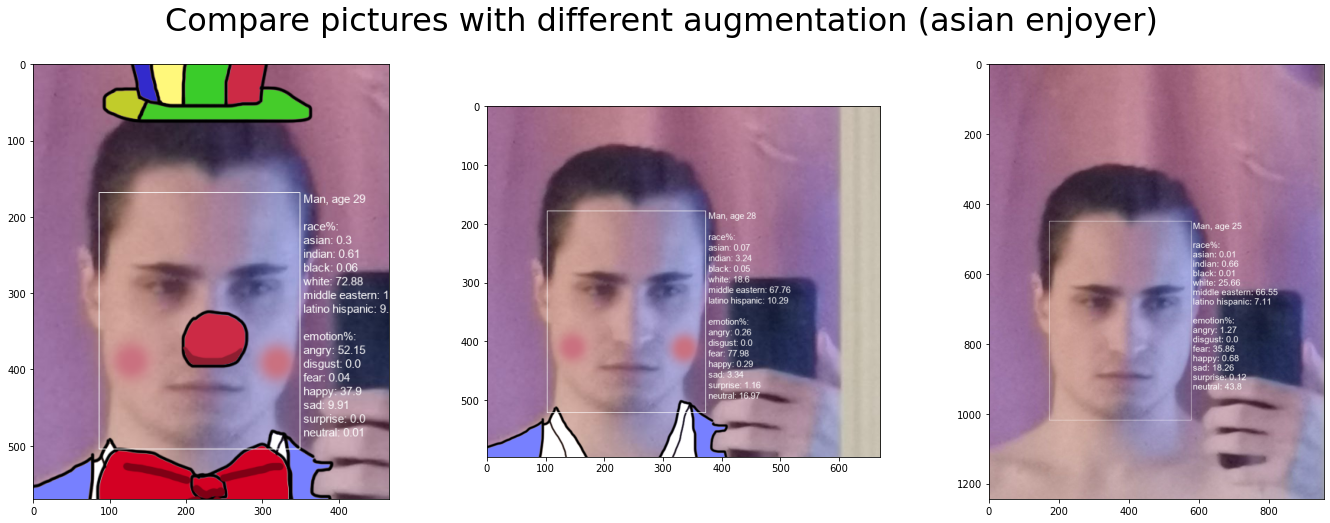

In [10]:
plot_imgs(imgs, ncols=3, increase_factor=8, title='Compare pictures with different augmentation (asian enjoyer)')

### Face detection

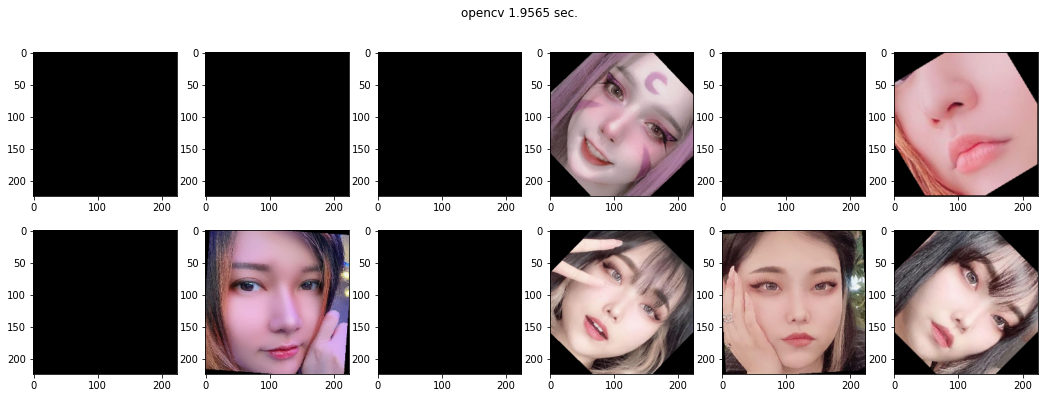

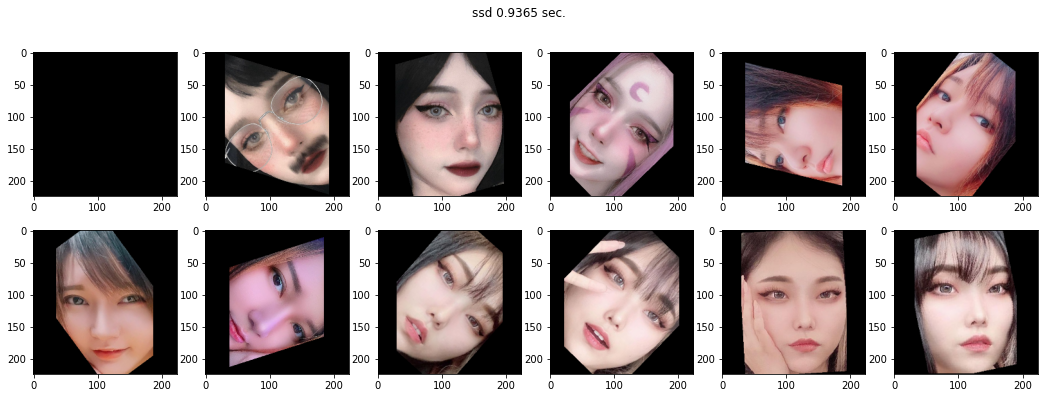

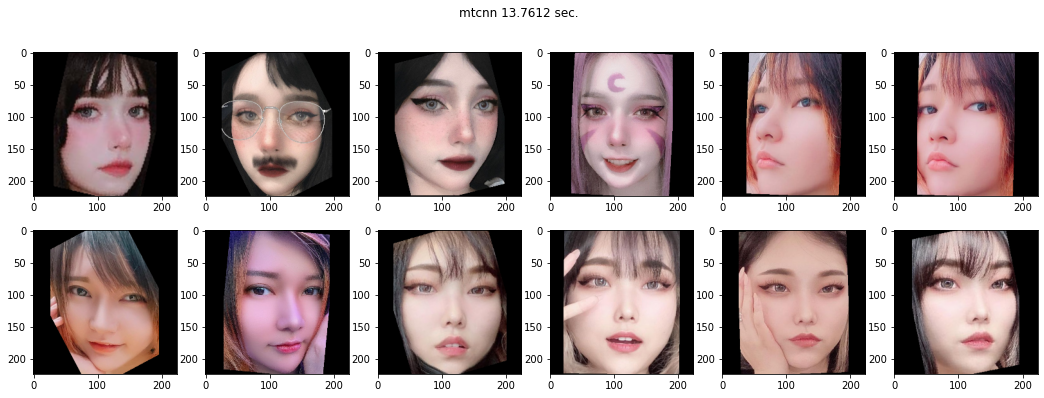

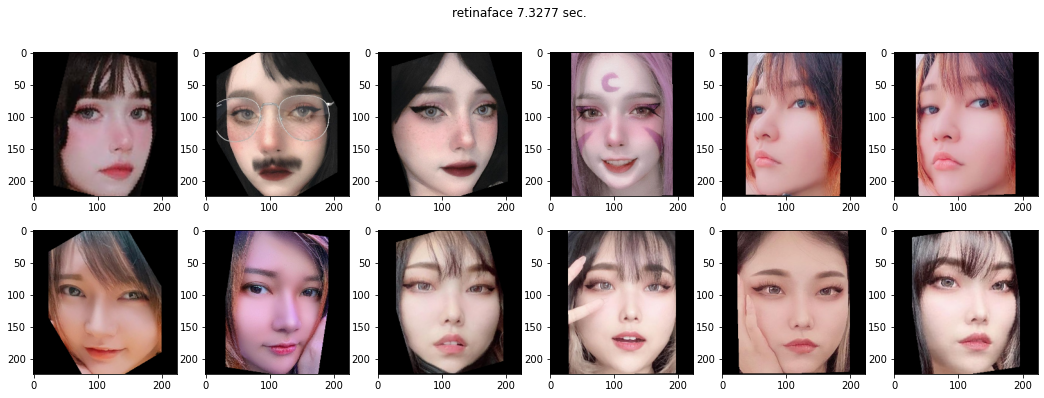

In [11]:
# 3 batches of 4 photo of the same girl (in other words 4 photos * 3 girls, in the order)
path = 'markup'
backends = ['opencv', 'ssd', 'mtcnn', 'retinaface']

storage = {'faces': {}}
for back in backends:
    start_time = time.time()
    _faces, _imgs_paths = find_faces_in_dir(path, back)
    elapsed_time = time.time() - start_time
    
    storage['faces'][back] = _faces
    storage['paths'] = _imgs_paths
    plot_imgs(_faces/255, title="{} {:.4f} sec.".format(back, elapsed_time))

### Face recognition

In [12]:
class Embeder:
    """This class just call predict function from model"""
    def __init__(self, model_name:str):
        self.normalization = None
        
        self._model_name = model_name
        self._model = DeepFace.build_model(model_name)
        self._input_shape_x, self._input_shape_y = DeepFace.functions.find_input_shape(self._model)
        
        
    def __call__(self, img: np.ndarray):
        assert isinstance(img, np.ndarray)
        
        if len(img.shape) > 3:
            imgs = img
            imgs = [self.resize(_img) for _img in imgs]
            imgs = [self.normalize_input(_img, self.normalization) for _img in imgs]
            imgs = np.array(imgs)
            
        else:
            img = self.resize(img)
            img = self.normalize_input(img, self.normalization)
            imgs = img[None, ...]
            
        return self._model.predict(imgs)
        
    
    def resize(self, img):
        return cv2.resize(img, (self._input_shape_x, self._input_shape_y))
    
    # rewrite normalization function from DeepFace, cause it shity code
    def normalize_input(self, img, normalization:str=None):
        if normalization is None:
            normalization = self._model_name
            
        normalization = normalization.lower()
        avaibe_modes = ['base', 'raw', 'facenet', 'facenet2018', 'vggface', 'vggface2', 'arcface']

        #issue 131 declares that some normalization techniques improves the accuracy
        if normalization not in avaibe_modes or normalization == 'base':
            if img.max() > 1:
                return img / 255
            else:
                return img

        #restore input in scale of [0, 255] because it was normalized in scale of  [0, 1] in preprocess_face
        if img.max() <= 1:
            img *= 255 

        if normalization == 'raw':
            pass

        elif normalization == 'facenet':
            mean, std = img.mean(), img.std()
            img = (img - mean) / std

        elif(normalization=="facenet2018"):
            # simply / 127.5 - 1 (similar to facenet 2018 model preprocessing step as @iamrishab posted)
            img /= 127.5
            img -= 1

        elif normalization == 'vggface':
            # mean subtraction based on VGGFace1 training data
            img[..., 0] -= 93.5940
            img[..., 1] -= 104.7624
            img[..., 2] -= 129.1863

        elif(normalization == 'vggface2'):
            # mean subtraction based on VGGFace2 training data
            img[..., 0] -= 91.4953
            img[..., 1] -= 103.8827
            img[..., 2] -= 131.0912

        elif(normalization == 'arcface'):
            #Reference study: The faces are cropped and resized to 112×112,
            #and each pixel (ranged between [0, 255]) in RGB images is normalised
            #by subtracting 127.5 then divided by 128.
            img -= 127.5
            img /= 128
        #-----------------------------

        return img

In [13]:
def heatmap_similarity(images_emb: np.ndarray, imgs: np.ndarray, robust=False):
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    fig.patch.set_facecolor('white')
    
    corr = images_emb @ images_emb.T * 100
    mask = np.zeros_like(corr)
    mask[range(mask.shape[0]), range(mask.shape[0])] = True

    ax = sns.heatmap(
        corr,
        vmin=0 if robust else None,
        vmax=100 if robust else None,
        mask=mask if robust else None,
        annot=True,
        cmap="RdBu",
        square=True,
        cbar=False,
        yticklabels=False,
        xticklabels=False,
    )

    for text in ax.texts:
        text.set_size(20)
        if text.get_text() == '1e+02':
            text.set_text('100')

    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches='tight')
    heatmap = PIL.Image.open(buf)
    plt.close(fig)

    square_size = int(heatmap.size[0] / len(images_emb))
    arr = np.zeros(shape = (heatmap.size[0]+square_size, heatmap.size[0]+square_size, 3), dtype=np.uint8)
    arr[:, :, :] = 255
    heatmap_with_img = PIL.Image.fromarray(arr, mode = 'RGB')
    heatmap_with_img.paste(heatmap, (square_size, square_size))

    pos = 0
    for idx, img in enumerate(imgs):
        pos+= square_size
        img = cv2.resize(img, (square_size, square_size))
        heatmap_with_img.paste(PIL.Image.fromarray(img), (pos, 0))

    pos = 0
    for idx, img in enumerate(imgs):
        pos+= square_size
        img = cv2.resize(img, (square_size, square_size))
        heatmap_with_img.paste(PIL.Image.fromarray(img), (0, pos))
        
    return heatmap_with_img

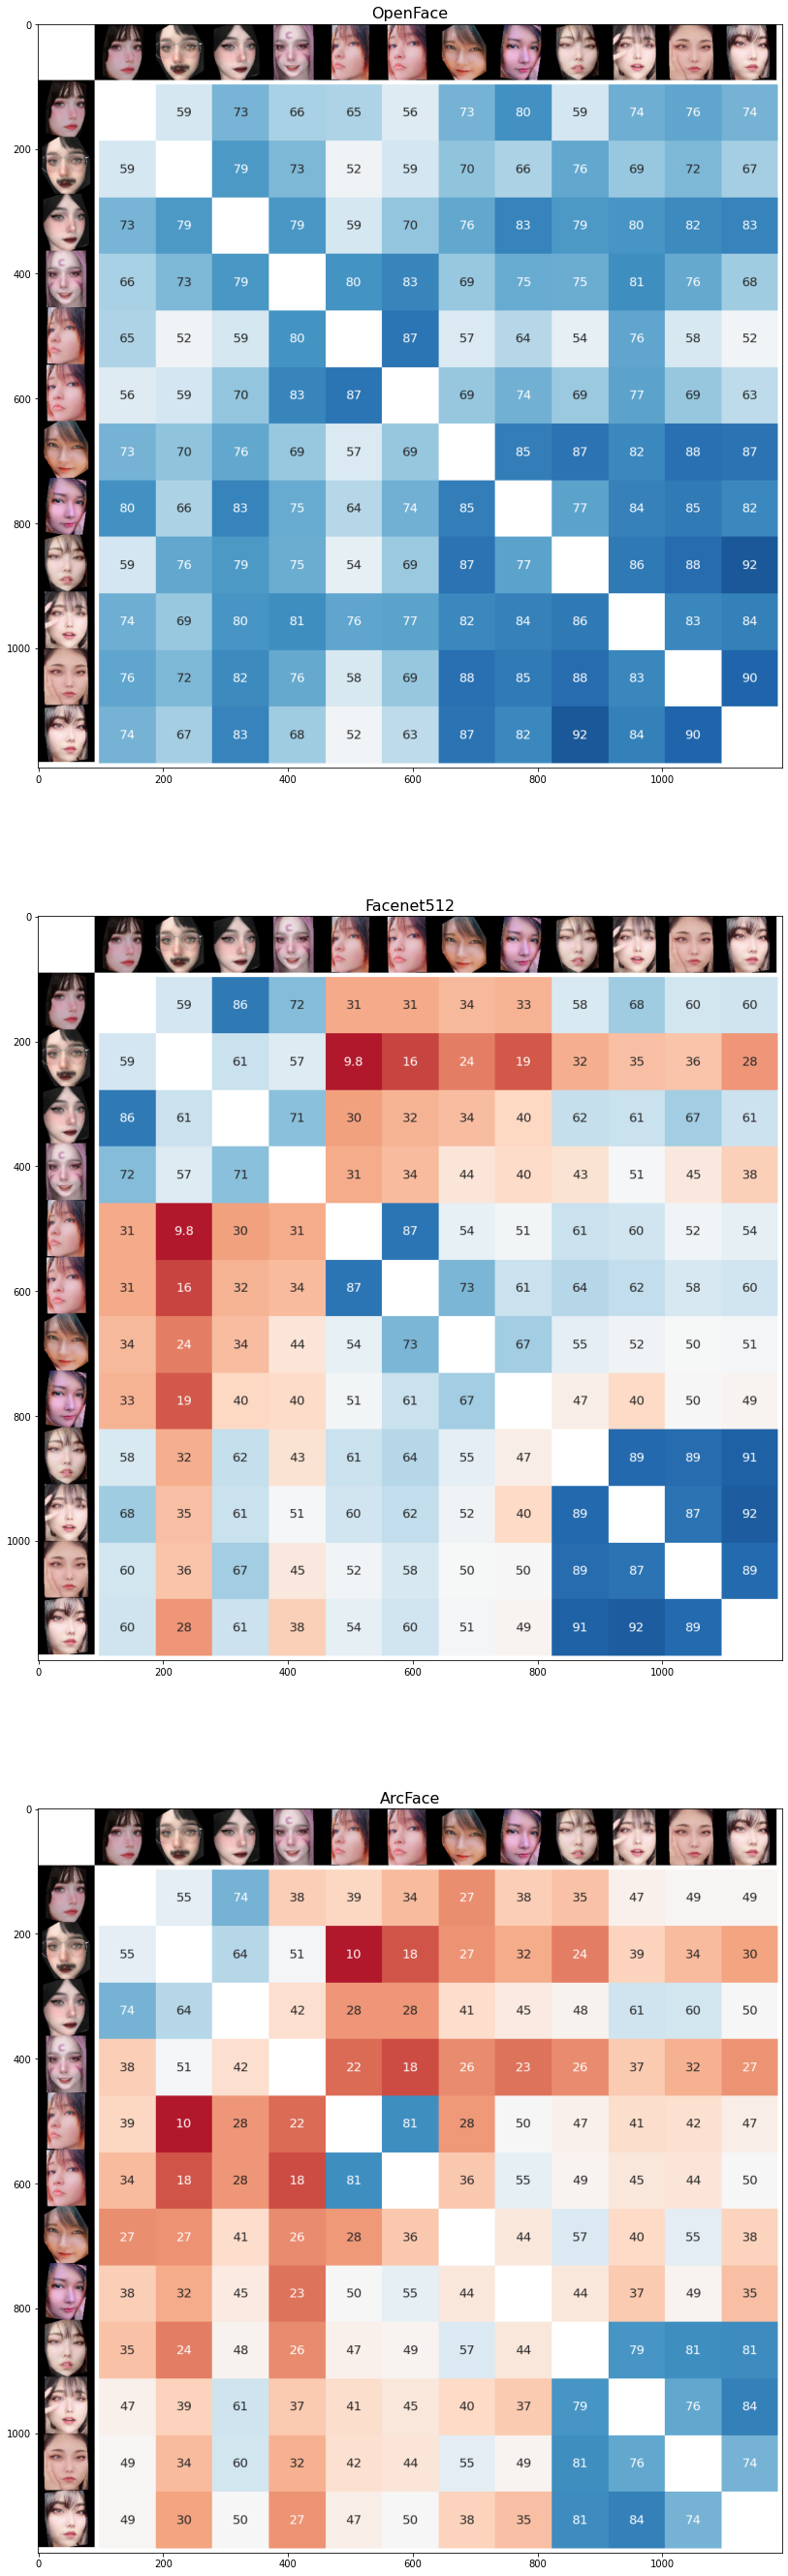

In [14]:
models = ["OpenFace", "Facenet512", "ArcFace"]
fig, axes = plt.subplots(len(models), 1, figsize=(16, 16*len(models)))

for model_name, ax in zip(models, axes):
    embeder = Embeder(model_name)
    embeddings = embeder(storage['faces']['retinaface'])

    # Prepare data
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    imgs = storage['faces']['retinaface'].astype(np.uint8)

    heatmap = heatmap_similarity(embeddings, imgs, robust=True)
    
    ax.set_title(model_name, fontsize=16)
    ax.imshow(heatmap)
    
plt.show()

## Distance analyzing

https://github.com/serengil/deepface/blob/master/tests/Fine-Tuning-Threshold.ipynb

### prepare the data

In [15]:
idendities = {
    "misaki_tl": [
        "misaki_tl_2112131177075566312.jpg", 
        "misaki_tl_2330304803367651327.jpg",
        "misaki_tl_2340990982807175383.jpg",
        "misaki_tl_2377501426334011137.jpg",
    ],
    "potatogodzilla_reallife": [
        "potatogodzilla_reallife_2830548237531627638.jpg",
        "potatogodzilla_reallife_2830548237774859343.jpg",
        "potatogodzilla_reallife_2831187995760925674.jpg",
        "potatogodzilla_reallife_2848662831082458625.jpg",
    ],
    "yurie_oh": [
        "yurie_oh_2797075493369280103.jpg", 
        "yurie_oh_2798457149602881716.jpg",
        "yurie_oh_2811588085043232967.jpg",
        "yurie_oh_2830251096217765997.jpg",
    ],
}

In [16]:
positives = []

for key, values in idendities.items():
    
    #print(key)
    for i in range(0, len(values)-1):
        for j in range(i+1, len(values)):
            #print(values[i], " and ", values[j])
            positive = []
            positive.append(values[i])
            positive.append(values[j])
            positives.append(positive)

positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["decision"] = "Yes"

In [17]:
samples_list = list(idendities.values())

negatives = []

for i in range(0, len(idendities) - 1):
    for j in range(i+1, len(idendities)):
        #print(samples_list[i], " vs ",samples_list[j]) 
        cross_product = itertools.product(samples_list[i], samples_list[j])
        cross_product = list(cross_product)
        #print(cross_product)
        
        for cross_sample in cross_product:
            #print(cross_sample[0], " vs ", cross_sample[1])
            negative = []
            negative.append(cross_sample[0])
            negative.append(cross_sample[1])
            negatives.append(negative)
            
negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["decision"] = "No"

df = pd.concat([positives, negatives]).reset_index(drop = True)
df.file_x = "markup/"+df.file_x
df.file_y = "markup/"+df.file_y

### Calculate the distance

In [18]:
def fit_predict(model_name="ArcFace", distance_metric="cosine"):
    instances = df[["file_x", "file_y"]].values.tolist()
    resp_obj = DeepFace.verify(instances, model_name = model_name, distance_metric = distance_metric, detector_backend='retinaface')

    distances = []
    for i in range(0, len(instances)):
        distance = round(resp_obj["pair_%s" % (i+1)]["distance"], 4)
        distances.append(1 - distance)
        
    df["distance"] = distances

In [19]:
def calculate_and_plot():
    tp_mean = round(df[df.decision == "Yes"].mean().values[0], 4)
    tp_std = round(df[df.decision == "Yes"].std().values[0], 4)
    fp_mean = round(df[df.decision == "No"].mean().values[0], 4)
    fp_std = round(df[df.decision == "No"].std().values[0], 4)

    print("Mean of true positives: ", tp_mean)
    print("Std of true positives: ", tp_std)
    print("Mean of false positives: ", fp_mean)
    print("Std of false positives: ", fp_std)

    df[df.decision == "Yes"].distance.plot.kde()
    df[df.decision == "No"].distance.plot.kde()
    plt.show()

model_name='OpenFace'


Verification: 100%|████████████████████████████████████████████████████████████████████| 66/66 [00:28<00:00,  2.33it/s]


Mean of true positives:  0.8197
Std of true positives:  0.0675
Mean of false positives:  0.7664
Std of false positives:  0.0674


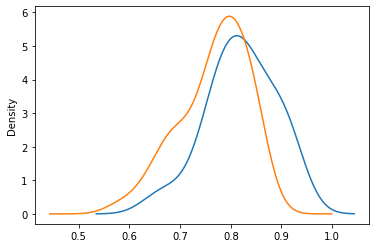

model_name='Facenet512'


Verification: 100%|████████████████████████████████████████████████████████████████████| 66/66 [00:29<00:00,  2.23it/s]


Mean of true positives:  0.7416
Std of true positives:  0.1505
Mean of false positives:  0.452
Std of false positives:  0.1571


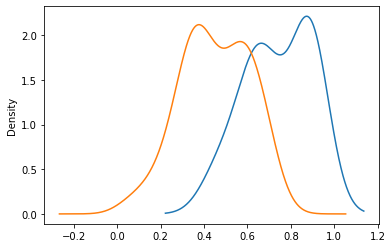

model_name='ArcFace'


Verification: 100%|████████████████████████████████████████████████████████████████████| 66/66 [00:28<00:00,  2.30it/s]


Mean of true positives:  0.5957
Std of true positives:  0.2006
Mean of false positives:  0.3797
Std of false positives:  0.1404


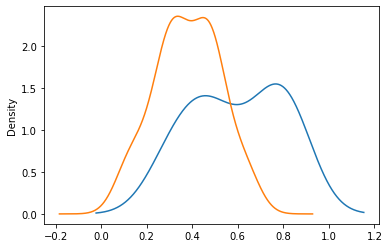

In [20]:
for model_name in ['OpenFace', 'Facenet512', 'ArcFace']:
    print(f"{model_name=}")
    fit_predict(model_name)
    calculate_and_plot()

In [21]:
def train_and_plot(models=["Facenet512", "ArcFace"], data_norm='base'):
    print(f"{data_norm=}")
    
    instances = df[["file_x", "file_y"]].values.tolist()
    for model_name in models:
        print(f"{model_name=}")
        
        scores = []
        embeder = Embeder(model_name)
        embeder.normalization = data_norm


        for pair in instances:
            face1 = DeepFace.detectFace(
                img_path=pair[0], 
                target_size=(embeder._input_shape_x, embeder._input_shape_y), 
                detector_backend='retinaface',
            )
            face2 = DeepFace.detectFace(
                img_path=pair[1], 
                target_size=(embeder._input_shape_x, embeder._input_shape_y), 
                detector_backend='retinaface',
            )
            if face1.max() <= 1:
                face1 *= 255 
            if face2.max() <= 1:
                face2 *= 255 

            faces = np.concatenate([face1[None, ...], face2[None, ...]])
            embs = embeder(faces)
            emb1 = embs[0]
            emb2 = embs[1]
            score = DeepFace.dst.findCosineDistance(emb1, emb2)
            scores.append(1 - score)

        df["distance"] = scores
        config = {'algorithm': 'C4.5'}
        tmp_df = df[['distance', 'decision']].rename(columns = {"decision": "Decision"}).copy()
        model = chef.fit(tmp_df, config)

        calculate_and_plot()
        plt.show()

data_norm='base'
model_name='Facenet512'
[INFO]:  6 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...
-------------------------
finished in  0.5695602893829346  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  86.36363636363636 % on  66  instances
Labels:  ['Yes' 'No']
Confusion matrix:  [[9, 0], [9, 48]]
Precision:  100.0 %, Recall:  50.0 %, F1:  66.6667 %
Mean of true positives:  0.7464
Std of true positives:  0.1362
Mean of false positives:  0.4511
Std of false positives:  0.1446


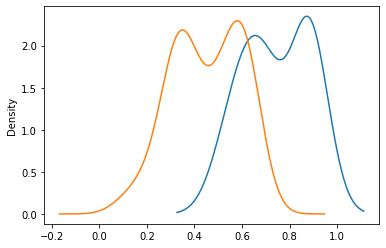

data_norm='facenet'
model_name='Facenet512'
[INFO]:  6 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...
-------------------------
finished in  0.5570952892303467  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  84.84848484848484 % on  66  instances
Labels:  ['Yes' 'No']
Confusion matrix:  [[9, 1], [9, 47]]
Precision:  90.0 %, Recall:  50.0 %, F1:  64.2857 %
Mean of true positives:  0.7066
Std of true positives:  0.1481
Mean of false positives:  0.4321
Std of false positives:  0.1281


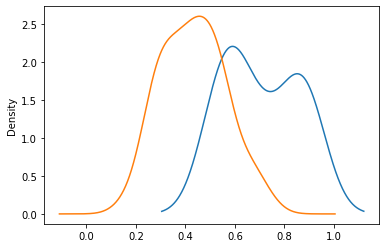

data_norm='facenet2018'
model_name='Facenet512'
[INFO]:  6 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...
-------------------------
finished in  0.5826246738433838  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  84.84848484848484 % on  66  instances
Labels:  ['Yes' 'No']
Confusion matrix:  [[8, 0], [10, 48]]
Precision:  100.0 %, Recall:  44.4444 %, F1:  61.5384 %
Mean of true positives:  0.7498
Std of true positives:  0.1487
Mean of false positives:  0.4847
Std of false positives:  0.1361


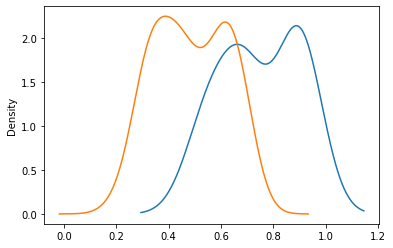

In [22]:
train_and_plot(models=["Facenet512"], data_norm='base')
train_and_plot(models=["Facenet512"], data_norm='facenet')
train_and_plot(models=["Facenet512"], data_norm='facenet2018')

data_norm='base'
model_name='ArcFace'
[INFO]:  6 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...
-------------------------
finished in  0.5890007019042969  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  80.3030303030303 % on  66  instances
Labels:  ['Yes' 'No']
Confusion matrix:  [[5, 0], [13, 48]]
Precision:  100.0 %, Recall:  27.7778 %, F1:  43.4783 %
Mean of true positives:  0.6155
Std of true positives:  0.1805
Mean of false positives:  0.4067
Std of false positives:  0.1235


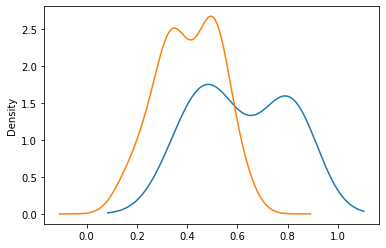

data_norm='ArcFace'
model_name='ArcFace'
[INFO]:  6 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...
-------------------------
finished in  0.6324424743652344  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  86.36363636363636 % on  66  instances
Labels:  ['Yes' 'No']
Confusion matrix:  [[9, 0], [9, 48]]
Precision:  100.0 %, Recall:  50.0 %, F1:  66.6667 %
Mean of true positives:  0.5978
Std of true positives:  0.188
Mean of false positives:  0.3945
Std of false positives:  0.1136


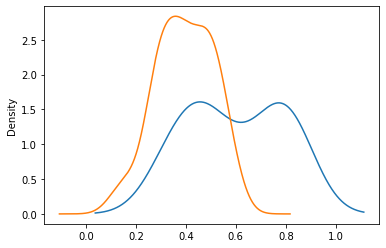

In [23]:
train_and_plot(models=["ArcFace"], data_norm='base')
train_and_plot(models=["ArcFace"], data_norm='ArcFace')

#

### RetinaFace and MTCNN wrappers

In [24]:
sys.path.insert(0, "C:/Projects/DateMatching/Model/Retina")
sys.path.insert(0, "C:/Projects/DateMatching/Model/MTCNN")
import Retina
import MTCNN

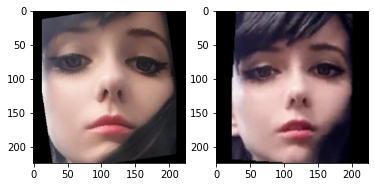

In [25]:
img_with_few_faces = "n_mirikashi_2806762003975576873.jpg"

retina = Retina.RetinaFace(normalize=False)
_faces2 = retina(img_with_few_faces)
plot_imgs(_faces2, ncols=2)

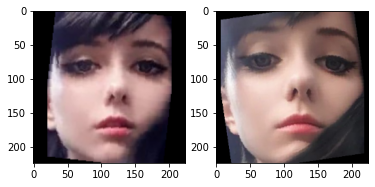

In [26]:
mtcnn = MTCNN.MTCNN(normalize=False)
_faces2 = mtcnn(img_with_few_faces)
plot_imgs(_faces2, ncols=2)

In [27]:
%%timeit
_faces2 = retina(img_with_few_faces)

163 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%%timeit
_faces2 = mtcnn(img_with_few_faces)

694 ms ± 20.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Parse

In [33]:
embeder = Embeder("Facenet512")
embeder.normalization = 'base'

storage = utils.EmbedingStorage()

In [34]:
def process_photo(photo_path, save_path, name='noname') -> bool:
    try:
        _faces = retina(
            photo_path, 
            target_size=(embeder._input_shape_x, embeder._input_shape_y),
        )

        for face in _faces:
            storage[photo_path] = [embeder(face.astype('float32')), name]
            Image.fromarray(face).save(f"{save_path}{storage.cached_id}.png")

        return True if _faces else False
    
    except KeyboardInterrupt:
        raise
        
    except Exception:
        print(photo_path)
        return False

In [35]:
max_photo = 10
def process_files(file: pathlib.WindowsPath, save_path:str, name='noname'):
    if file.is_file() and file.suffix in ['.png', '.jpg', '.jpeg']:
        return process_photo(str(file), save_path, name)
        
    elif file.is_dir():
        n = 0 # number of proccesed files in dir
        for file_ in file.iterdir():
            if process_files(file_, save_path, file.stem):
                n+= 1
                
            if n > max_photo:
                return

In [36]:
for current, previous in zip(messages[1:], messages[:-1]):
    if type(previous['photo']) is str:
        photo_path = 'tg_data/' + previous['photo']

        if current['text'] in ['💌', '❤️', '👍']:
            save_path = 'data/target/'

        elif current['text'] in ['👎']:
            save_path = 'data/opposite/'

        else:
            continue
        
        process_photo(photo_path, save_path)

In [37]:
path = pathlib.Path('markup/target/')
process_files(path, 'data/target/')

path = pathlib.Path('markup/opposite/')
process_files(path, 'data/opposite/')

In [38]:
storage.save('weights/emb_storage.pkl')